In [1]:
# Standard imports:
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.units as u

import glob as glob
import os

from astropy.coordinates import Angle
import lsst.geom

In [2]:
afwDisplay.setDefaultBackend('matplotlib')
from lsst.rsp import get_tap_service
service = get_tap_service("tap")

In [25]:
# Butler setup and skyMap retrieval:
collections = 'LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066'
butler = dafButler.Butler('embargo_or4', collections=collections)
registry = butler.registry
skyMap = butler.get('skyMap', dataId={'skymap':'ops_rehersal_prep_2k_v1'})

In [26]:
# # select a tract and patch
patches = []
for i, dt in enumerate(registry.queryDatasets(datasetType='goodSeeingCoadd', collections=collections)):
    # print(dt.dataId['tract'])
    if (dt.dataId['tract'] == 2494) and (dt.dataId['band'] == 'g'):
        print(dt.dataId)
        patches.append(dt.dataId['patch'])

{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 102}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 103}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 104}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 105}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 106}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 119}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 120}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 121}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 122}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 123}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 124}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 136}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 137}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patc

In [7]:
### Class to compare the flux between truth table and object table

class compare_true_obj_flux():
    def __init__(self, tract, patch):
        self.tract = tract
        self.patch = patch

    def get_objtable(self):
        tract_dataid = {'band': 'g', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': self.tract, 'patch': self.patch}
        obj_table = butler.get('objectTable', dataId=tract_dataid)
        obj_table = obj_table.reset_index()
        obj_table = obj_table[obj_table['refBand'] == 'g']
        
        return obj_table

    def GetTruthFiles(self,RA, Dec):
        truthFiles = []
    
        mean_ra = np.deg2rad(np.mean(RA.value))
        mean_de = np.deg2rad(90. - np.mean(Dec.value))
        coordVec = hp.ang2vec(mean_de, mean_ra)
        ipix_discs = hp.query_disc(nside=32, vec=coordVec, radius=np.radians(2))
    
        for ipix_disc in ipix_discs:
            filename = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_{}.parquet'.format(ipix_disc)
            if os.path.exists(filename):
                truthFiles.append(filename)        
        return truthFiles
        
    def match_objtable_to_truth(self,truthFile, obj_table):
        truthTable = pd.read_parquet(truthFile)
        
        # select static stars
        truthTable = truthTable[truthTable['is_variable'] == False]
        truthTable = truthTable.sort_values('magnorm', ascending=True)
        truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]
        
        # cross match with the object table
        trueCoords = SkyCoord(ra=truthTable['ra'].values*u.degree, dec=truthTable['dec'].values*u.degree)
        objCoords = SkyCoord(ra=obj_table['coord_ra'].values*u.degree, dec=obj_table['coord_dec'].values*u.degree)
    
        idx, d2d, d3d = objCoords.match_to_catalog_sky(trueCoords) # idx is closest index in trueCoords
    
        # select closest matche within 2"
        d2d_inx = np.where(d2d < 2*u.arcsec)
        idx = idx[d2d_inx]
        d2d = d2d[d2d_inx]
    
        return truthTable, idx
        
    def get_true_obj_flux(self, obj_table):
        obj_ra = obj_table['coord_ra'].values
        obj_dec = obj_table['coord_dec'].values
        
        truthFiles = self.GetTruthFiles(obj_ra*u.degree, obj_dec*u.degree)
        for i, truthFile in enumerate(truthFiles):
            # print(str(truthFile))
            truthTable, idx = self.match_objtable_to_truth(truthFile, obj_table)
            # print(idx)
            if len(idx) != 0:
                true_ra_list = []
                true_dec_list = []
                true_magnorm_list = []
                obj_ra_list = []
                obj_dec_list = []
                obj_mag_list = []
            
                for idx_match in idx:
                    true_magnorm = truthTable['magnorm'][idx_match:idx_match+1].values[0]
                    true_ra = truthTable['ra'][idx_match:idx_match+1].values[0]
                    true_dec = truthTable['dec'][idx_match:idx_match+1].values[0]
            
                    # match again to object table to get the indices
                    trueCoords = SkyCoord(ra=true_ra*u.degree, dec=true_dec*u.degree)
                    SCoords = SkyCoord(ra=obj_table['coord_ra'].values*u.degree, dec=obj_table['coord_dec'].values*u.degree)
                    idx_obj, d2d, d3d = trueCoords.match_to_catalog_sky(SCoords) #idx is closest index in SCoords
                    obj_ra = obj_table[int(idx_obj):int(idx_obj+1)]['coord_ra'].values[0]
                    obj_dec = obj_table[int(idx_obj):int(idx_obj+1)]['coord_dec'].values[0]
                    obj_flux = obj_table[int(idx_obj):int(idx_obj+1)]['g_psfFlux']
                    obj_mag = (obj_flux.to_numpy()*u.nJy).to(u.ABmag).value[0]
                    
                    true_ra_list.append(true_ra)
                    true_dec_list.append(true_dec)
                    true_magnorm_list.append(true_magnorm)
                    obj_ra_list.append(obj_ra)
                    obj_dec_list.append(obj_dec)
                    obj_mag_list.append(obj_mag)
                    
                return true_ra_list, true_dec_list, true_magnorm_list, obj_ra_list, obj_dec_list, obj_mag_list
                
            else:
                i+=1
                
        return    

In [ ]:
truth_obj_dict = {'true_ra':[], 'true_dec':[], 'true_magnorm':[], 'obj_ra':[], 'obj_dec':[], 'obj_mag':[]}
# tracts = [2494, 2494, 2494, 2494, 2494, 2494, 2494, 2494]
# patches = [192, 275, 155, 204, 138, 226, 255, 119]
# tracts = [2494]
# patches = [138]
for i in range(0, len(patches)):
    # select_tract = tracts[i]
    select_tract = 2494
    select_patch = patches[i]
    print(select_tract, select_patch)
    compare_flux = compare_true_obj_flux(select_tract , select_patch)
    try:
        obj_table = compare_flux.get_objtable()
        try:
            true_ra_list, true_dec_list, true_magnorm_list, obj_ra_list, obj_dec_list, obj_mag_list = compare_flux.get_true_obj_flux(obj_table)
            truth_obj_dict['true_ra'].append(true_ra_list)
            truth_obj_dict['true_dec'].append(true_dec_list)
            truth_obj_dict['true_magnorm'].append(true_magnorm_list)
            truth_obj_dict['obj_ra'].append(obj_ra_list)
            truth_obj_dict['obj_dec'].append(obj_dec_list)
            truth_obj_dict['obj_mag'].append(obj_mag_list)
        except:
            continue
    except:
        print('no object table')
    

2494 102
2494 103
2494 104
2494 105
2494 106
2494 119
2494 120
2494 121
2494 122
2494 123
2494 124
2494 136
2494 137
2494 138
2494 139
2494 140
2494 141
2494 153
2494 154
no object table
2494 155


In [9]:
# Flatten the lists
truth_obj_dict_flatten = {
    'true_ra': [item for sublist in truth_obj_dict['true_ra'] for item in sublist],
    'true_dec': [item for sublist in truth_obj_dict['true_dec'] for item in sublist],
    'true_magnorm': [item for sublist in truth_obj_dict['true_magnorm'] for item in sublist],
    'obj_ra': [item for sublist in truth_obj_dict['obj_ra'] for item in sublist],
    'obj_dec': [item for sublist in truth_obj_dict['obj_dec'] for item in sublist],
    'obj_mag': [item for sublist in truth_obj_dict['obj_mag'] for item in sublist],
}

In [10]:
match_df = pd.DataFrame(truth_obj_dict_flatten)
match_df.drop_duplicates(inplace=True)
match_df = match_df.dropna()
match_df['diff_mag'] = match_df['true_magnorm'] - match_df['obj_mag']

In [11]:
match_df

,true_ra,true_dec,true_magnorm,obj_ra,obj_dec,obj_mag,diff_mag
0,279.808978,-48.552486,17.874134,279.808977,-48.552485,18.149669,-0.275535
1,279.957456,-48.550111,17.363568,279.957457,-48.550112,17.662690,-0.299122
2,279.924253,-48.537078,18.122535,279.924253,-48.537078,18.412123,-0.289588
3,279.898831,-48.514043,17.558501,279.898831,-48.514042,17.837889,-0.279388
4,279.847380,-48.488530,18.635012,279.847385,-48.488521,18.887972,-0.252960
...,...,...,...,...,...,...,...
585,279.698027,-48.611474,18.173687,279.697790,-48.611463,18.812714,-0.639026
586,279.677991,-48.611483,18.088204,279.677990,-48.611485,18.407006,-0.318801
587,279.688609,-48.610345,18.250440,279.688609,-48.610348,18.569419,-0.318979
588,279.657887,-48.609886,17.794417,279.657889,-48.609887,18.101781,-0.307364


In [29]:
match_df.to_csv('static_true_obj_tract2494.csv')

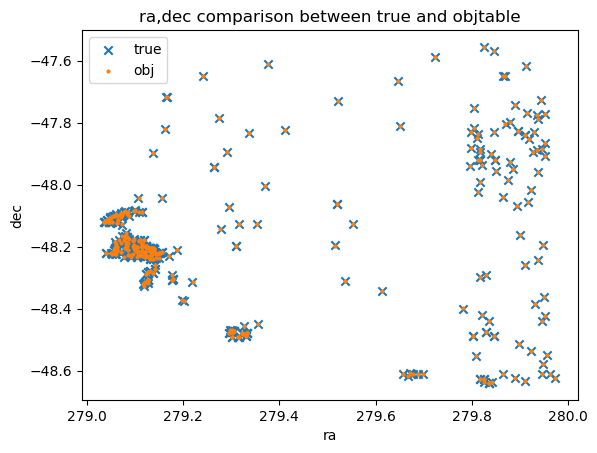

In [12]:
# compare ra,dec between true and forced as 2d scatter plot
plt.scatter(match_df['true_ra'], match_df['true_dec'], marker='x', label='true')
plt.scatter(match_df['obj_ra'], match_df['obj_dec'], marker='o', s=4, label='obj')
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('ra,dec comparison between true and objtable')
plt.show()

Text(0, 0.5, 'True - PSF magnitude')

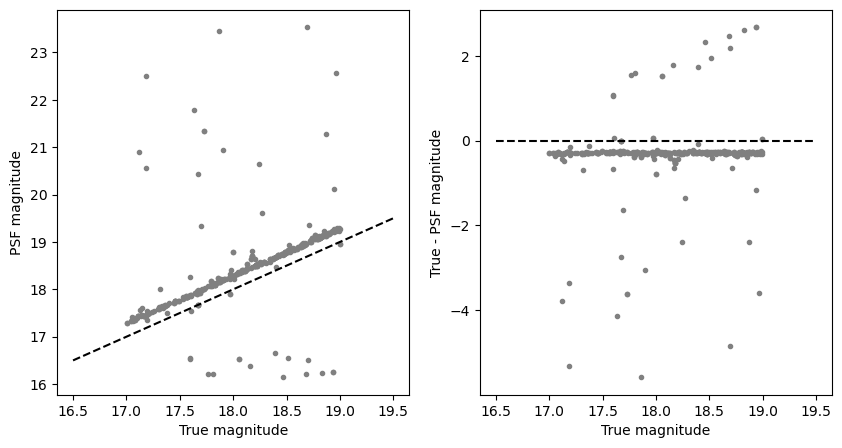

In [22]:
# create a two panel plot of PSF vs True and True - PSF Vs True
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(match_df['true_magnorm'], match_df['obj_mag'], marker='.', color='grey')
ax[1].scatter(match_df['true_magnorm'], match_df['diff_mag'], marker='.', color='grey')

ax[0].plot([16.5, 19.5], [16.5, 19.5], ls='--', color='k')
ax[0].set_xlabel('True magnitude')
ax[0].set_ylabel('PSF magnitude')
#set limits
# ax[0].set_xlim(16.0, 25.1)
# ax[0].set_ylim(16.0, 25.1)

ax[1].plot([16.5, 19.5], [0.0, 0.0], ls='--', color='k')
ax[1].set_xlabel('True magnitude')
ax[1].set_ylabel('True - PSF magnitude')
#set limits
# ax[1].set_xlim(16.0, 25.1)
# ax[1].set_ylim(-8.3, 4.0)


(-0.5, 0.5)

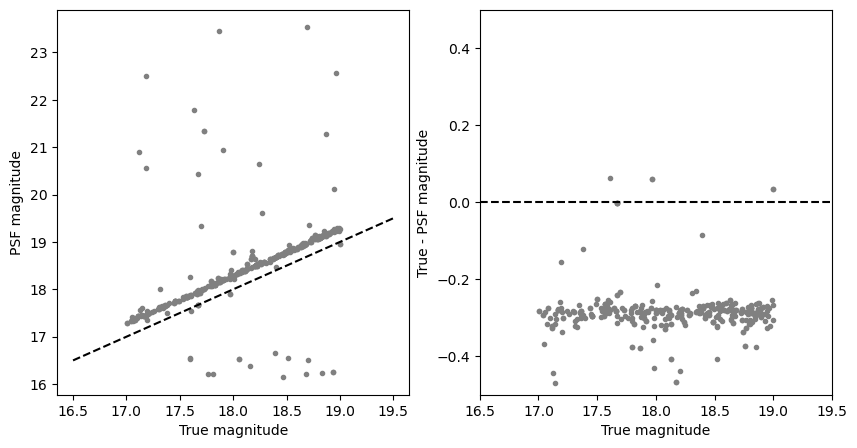

In [23]:
# create a two panel plot of PSF vs True and True - PSF Vs True
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(match_df['true_magnorm'], match_df['obj_mag'], marker='.', color='grey')
ax[1].scatter(match_df['true_magnorm'], match_df['diff_mag'], marker='.', color='grey')

ax[0].plot([16.5, 19.5], [16.5, 19.5], ls='--', color='k')
ax[0].set_xlabel('True magnitude')
ax[0].set_ylabel('PSF magnitude')
#set limits
# ax[0].set_xlim(16.0, 25.1)
# ax[0].set_ylim(16.0, 25.1)

ax[1].plot([16.5, 19.5], [0.0, 0.0], ls='--', color='k')
ax[1].set_xlabel('True magnitude')
ax[1].set_ylabel('True - PSF magnitude')
#set limits
ax[1].set_xlim(16.5, 19.5)
ax[1].set_ylim(-0.5, 0.5)


### Repeat the same analysis in tract 2495

In [28]:
# # select a tract and patch
patches = []
for i, dt in enumerate(registry.queryDatasets(datasetType='goodSeeingCoadd', collections=collections)):
    # print(dt.dataId['tract'])
    # if 300 < i <320:
    #     print(dt.dataId)
    if (dt.dataId['tract'] == 2495) and (dt.dataId['band'] == 'g'):
        print(dt.dataId)
        patches.append(dt.dataId['patch'])

{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 100}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 101}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 113}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 114}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 115}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 116}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 117}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 118}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 129}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 130}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 131}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 132}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patch: 133}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495, patc

In [30]:
truth_obj_dict = {'true_ra':[], 'true_dec':[], 'true_magnorm':[], 'obj_ra':[], 'obj_dec':[], 'obj_mag':[]}
for i in range(0, len(patches)):
    # select_tract = tracts[i]
    select_tract = 2495
    select_patch = patches[i]
    print(select_tract, select_patch)
    compare_flux = compare_true_obj_flux(select_tract , select_patch)
    try:
        obj_table = compare_flux.get_objtable()
        try:
            true_ra_list, true_dec_list, true_magnorm_list, obj_ra_list, obj_dec_list, obj_mag_list = compare_flux.get_true_obj_flux(obj_table)
            truth_obj_dict['true_ra'].append(true_ra_list)
            truth_obj_dict['true_dec'].append(true_dec_list)
            truth_obj_dict['true_magnorm'].append(true_magnorm_list)
            truth_obj_dict['obj_ra'].append(obj_ra_list)
            truth_obj_dict['obj_dec'].append(obj_dec_list)
            truth_obj_dict['obj_mag'].append(obj_mag_list)
        except:
            continue
    except:
        print('no object table')

2495 100
2495 101
2495 113
2495 114
2495 115
2495 116
2495 117
2495 118
2495 129
2495 130
2495 131
2495 132
2495 133
2495 134
2495 135
2495 145
2495 146
2495 147
2495 148
2495 149
2495 150
2495 151
2495 152
2495 162
2495 163
2495 164
2495 165
2495 166
no object table
2495 167
no object table
2495 168
no object table
2495 169
no object table
2495 178
2495 179
2495 180
2495 181
2495 182
no object table
2495 183
2495 184
2495 185
2495 186
no object table
2495 195
2495 196
2495 197
2495 198
2495 199
no object table
2495 200
2495 201
2495 202
2495 203
2495 212
2495 213
2495 214
2495 215
2495 216
2495 217
2495 218
no object table
2495 219
no object table
2495 220
2495 229
2495 230
2495 231
2495 232
2495 233
2495 234
2495 235
2495 236
2495 237
2495 247
2495 248
2495 249
2495 250
2495 251
2495 252
2495 253
2495 254
2495 265
2495 266
2495 267
2495 268
2495 269
2495 270
2495 271
2495 282
2495 283
2495 284
2495 285
2495 286
2495 287
2495 288
2495 83
2495 84


/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2495 98
2495 99


In [31]:
# Flatten the lists
truth_obj_dict_flatten = {
    'true_ra': [item for sublist in truth_obj_dict['true_ra'] for item in sublist],
    'true_dec': [item for sublist in truth_obj_dict['true_dec'] for item in sublist],
    'true_magnorm': [item for sublist in truth_obj_dict['true_magnorm'] for item in sublist],
    'obj_ra': [item for sublist in truth_obj_dict['obj_ra'] for item in sublist],
    'obj_dec': [item for sublist in truth_obj_dict['obj_dec'] for item in sublist],
    'obj_mag': [item for sublist in truth_obj_dict['obj_mag'] for item in sublist],
}

In [32]:
match_df = pd.DataFrame(truth_obj_dict_flatten)
match_df.drop_duplicates(inplace=True)
match_df = match_df.dropna()
match_df['diff_mag'] = match_df['true_magnorm'] - match_df['obj_mag']
match_df.to_csv('static_true_obj_tract2495.csv')

Text(0, 0.5, 'True - PSF magnitude')

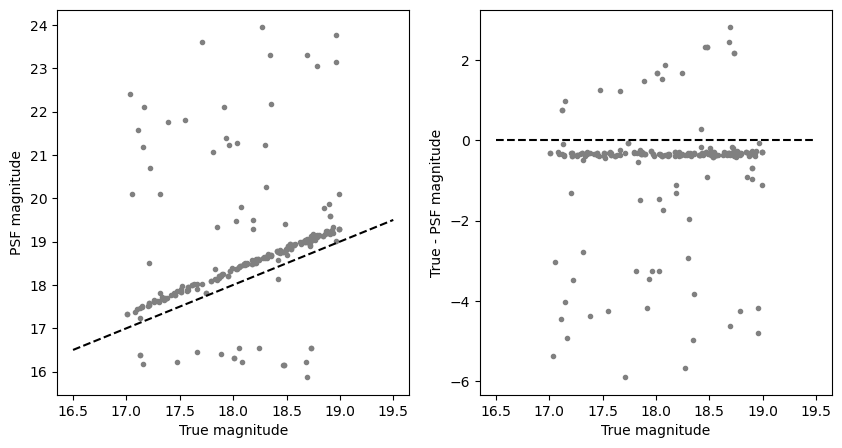

In [33]:
# create a two panel plot of PSF vs True and True - PSF Vs True
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(match_df['true_magnorm'], match_df['obj_mag'], marker='.', color='grey')
ax[1].scatter(match_df['true_magnorm'], match_df['diff_mag'], marker='.', color='grey')

ax[0].plot([16.5, 19.5], [16.5, 19.5], ls='--', color='k')
ax[0].set_xlabel('True magnitude')
ax[0].set_ylabel('PSF magnitude')
#set limits
# ax[0].set_xlim(16.0, 25.1)
# ax[0].set_ylim(16.0, 25.1)

ax[1].plot([16.5, 19.5], [0.0, 0.0], ls='--', color='k')
ax[1].set_xlabel('True magnitude')
ax[1].set_ylabel('True - PSF magnitude')
#set limits
# ax[1].set_xlim(16.0, 25.1)
# ax[1].set_ylim(-8.3, 4.0)

(-0.6, 0.6)

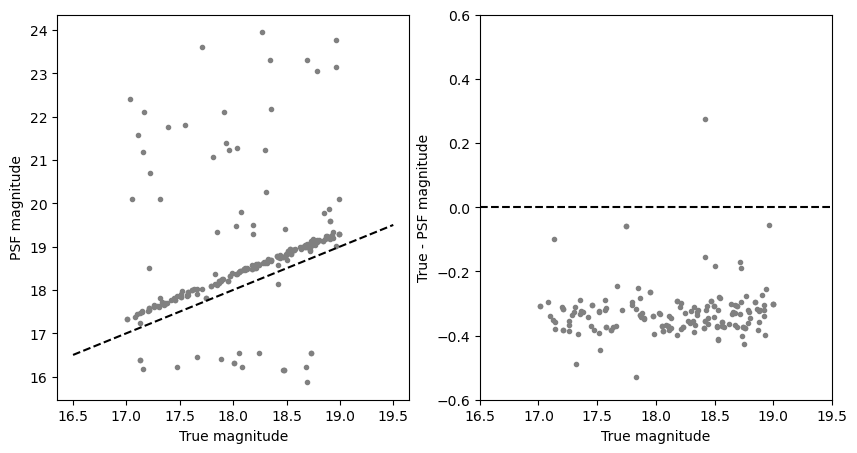

In [36]:
# create a two panel plot of PSF vs True and True - PSF Vs True
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(match_df['true_magnorm'], match_df['obj_mag'], marker='.', color='grey')
ax[1].scatter(match_df['true_magnorm'], match_df['diff_mag'], marker='.', color='grey')

ax[0].plot([16.5, 19.5], [16.5, 19.5], ls='--', color='k')
ax[0].set_xlabel('True magnitude')
ax[0].set_ylabel('PSF magnitude')
#set limits
# ax[0].set_xlim(16.0, 25.1)
# ax[0].set_ylim(16.0, 25.1)

ax[1].plot([16.5, 19.5], [0.0, 0.0], ls='--', color='k')
ax[1].set_xlabel('True magnitude')
ax[1].set_ylabel('True - PSF magnitude')
#set limits
ax[1].set_xlim(16.5, 19.5)
ax[1].set_ylim(-0.6, 0.6)


## Matching Truth and Forced Source Table

In [94]:
class compare_static_truth_psf:
    def __init__(self, tract, patch):
        self.tract = tract
        self.patch = patch

    def get_objecttable(self):
        """
        Get objectTable for a tract and patch
        """
        tract_dataid = {'band': 'g', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': self.tract, 'patch': self.patch}
        obj_table = butler.get('objectTable', dataId=tract_dataid)
        obj_table = obj_table.reset_index()
        
        # select a bright object from g band 
        obj_table = obj_table[obj_table['refBand'] == 'g']
        obj_table = obj_table.sort_values('g_psfFlux', ascending=False)

        return obj_table
    
    # A funuction to determine the filename of a truthtable covering a DIA detecor image.
    def GetTruthFiles(self, RA, Dec):
        '''
        Given a set of coordinates, determine the filename of the pointsource parquet
        truth table that covers that region. This is needed because the parquet files
        are named according to the htm7 nside=32 region that they cover, so the index
        of the htm7 segment is needed to identify the file.
    
        Note
        ----
        This calculates the mean coordinate of the catalogue and uses that to
        determine the htm7 segment.
    
        Inputs
        ------
        RA: Pandas series containing the Right Ascention of sources in degrees.
        Dec: Pandas series containing the Deckination of sources in degrees.
    
        Outputs
        -------
        truthFiles: List of filenames of the truth table parquet files that cover the
                    region of interest.
        
        '''
        truthFiles = []
    
        mean_ra = np.deg2rad(np.mean(RA.value))
        mean_de = np.deg2rad(90. - np.mean(Dec.value))
        coordVec = hp.ang2vec(mean_de, mean_ra)
        ipix_discs = hp.query_disc(nside=32, vec=coordVec, radius=np.radians(2))
    
        for ipix_disc in ipix_discs:
            filename = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_{}.parquet'.format(ipix_disc)
            if os.path.exists(filename):
                truthFiles.append(filename)        
        return truthFiles

    def find_match_truth_objtable(self, truthFile_parquet, obj_table_df, obj_ra, obj_dec):
        truthTable = pd.read_parquet(truthFile_parquet)
        
        # select static sources
        truthTable = truthTable[truthTable['is_variable'] == False]
        truthTable = truthTable.sort_values('magnorm', ascending=True)
        truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]
        
        # cross match with the object table
        trueCoords = SkyCoord(ra=truthTable['ra'].values*u.degree, dec=truthTable['dec'].values*u.degree)
        objCoords = SkyCoord(ra=obj_table_df['coord_ra'].values*u.degree, dec=obj_table_df['coord_dec'].values*u.degree)
        # objCoords = SkyCoord(ra=obj_ra*u.degree, dec=obj_dec*u.degree)
    
        idx, d2d, d3d = objCoords.match_to_catalog_sky(trueCoords) # idx is closest index in trueCoords
    
        # print('length of objCoords table: ',len(objCoords))
        # print('length of indices: ',len(idx))
    
        # select closest matche within 2"
        d2d_inx = np.where(d2d < 2*u.arcsec)
        idx = idx[d2d_inx]
        d2d = d2d[d2d_inx]
    
        return truthFile_parquet, idx

    def match_truth_forced(self, obj_table, obj_ra, obj_dec):
        # get truth files
        truthfile_match = 0
        idx_match = 0
        truthFiles = self.GetTruthFiles(obj_ra*u.degree, obj_dec*u.degree)
        
        for i, truthFile in enumerate(truthFiles):
            truthfile, idx = self.find_match_truth_objtable(truthFile, obj_table, obj_ra, obj_dec)
            print('matching indices: ',idx)
            if len(idx) != 0:
                truthfile_match = truthfile
                # idx_match = idx[0]
                # print(truthfile_match)
                # print(idx_match)
                # get the truth table matched to object_table ra,dec
                truthTable = pd.read_parquet(str(truthfile_match))
                truthTable = truthTable[truthTable['is_variable'] == False]
                truthTable = truthTable.sort_values('magnorm', ascending=True)
                truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]

                true_ra_list = []
                true_dec_list = []
                true_magnorm_list = []
                forced_ra_list = []
                forced_dec_list = []
                forced_band_list = []
                forced_mag_list = []
                tract_list = []
                patch_list = []

                for idx_match in idx:
                    true_magnorm = truthTable['magnorm'][idx_match:idx_match+1].values[0]
                    true_ra = truthTable['ra'][idx_match:idx_match+1].values[0]
                    true_dec = truthTable['dec'][idx_match:idx_match+1].values[0]
                
                    # get tract and patch for this true ra,dec
                    my_spherePoint = lsst.geom.SpherePoint(true_ra*lsst.geom.degrees,
                                                           true_dec*lsst.geom.degrees)    
                    tract = skyMap.findTract(my_spherePoint)
                    patch = tract.findPatch(my_spherePoint)
                    my_tract = tract.tract_id
                    my_patch = patch.getSequentialIndex()
                
                    # match the true ra,dec to forcedSourceTable ra,dec 
                    STable = butler.get('forcedSourceTable', tract=my_tract, patch=my_patch, skymap = 'ops_rehersal_prep_2k_v1')
                    trueCoords = SkyCoord(ra=true_ra*u.degree, dec=true_dec*u.degree)
                    SCoords = SkyCoord(ra=STable['coord_ra'].values*u.degree, dec=STable['coord_dec'].values*u.degree)
                    idx, d2d, d3d = trueCoords.match_to_catalog_sky(SCoords) #idx is closest index in SCoords
                    forced_ra = STable[int(idx):int(idx+1)]['coord_ra'].values[0]
                    forced_dec = STable[int(idx):int(idx+1)]['coord_dec'].values[0]
                    forced_band = STable[int(idx):int(idx+1)]['band'].values[0]
                    forced_flux = STable[int(idx):int(idx+1)]['psfFlux']
                    forced_mag = (forced_flux.to_numpy()*u.nJy).to(u.ABmag).value[0]

                    true_ra_list.append(true_ra)
                    true_dec_list.append(true_dec)
                    true_magnorm_list.append(true_magnorm)
                    forced_ra_list.append(forced_ra)
                    forced_dec_list.append(forced_dec)
                    forced_band_list.append(forced_band)
                    forced_mag_list.append(forced_mag)
                    tract_list.append(my_tract)
                    patch_list.append(my_patch)
    
                return true_ra_list, true_dec_list, true_magnorm_list, forced_ra_list, forced_dec_list, forced_band_list, forced_mag_list, tract_list, patch_list
            else:
                i+=1
        return 

In [96]:
truth_forced_dict = {'tract':[], 'patch':[], 'true_ra':[], 'true_dec':[], 'true_magnorm':[], 'forced_ra':[], 'forced_dec':[], 'forced_band':[], 'forced_mag':[]}
tracts = [2494, 2494, 2494, 2494, 2494, 2494, 2494, 2494]
patches = [192, 275, 155, 204, 138, 226, 255, 119]
n_sources = 1
for i in range(0, len(tracts)):
    select_tract = tracts[i]
    select_patch = patches[i]
    print(select_tract, select_patch)
    compare_flux = compare_static_truth_psf(select_tract , select_patch)
    obj_table = compare_flux.get_objecttable()
    for j in range(0, n_sources):
        # obj_ra = obj_table.iloc[0]['coord_ra'] # select the brightes object from ObjectTable
        # obj_dec = obj_table.iloc[0]['coord_dec']
        obj_ra = obj_table.iloc[i]['coord_ra'] # select the brightes object from ObjectTable
        obj_dec = obj_table.iloc[i]['coord_dec']
        try:
            true_ra, true_dec, true_magnorm, forced_ra, forced_dec, forced_band, forced_mag, true_tract, true_patch = compare_flux.match_truth_forced(obj_table, obj_ra, obj_dec)
            truth_forced_dict['true_ra'].append(true_ra)
            truth_forced_dict['true_dec'].append(true_dec)
            truth_forced_dict['true_magnorm'].append(true_magnorm)
            truth_forced_dict['forced_ra'].append(forced_ra)
            truth_forced_dict['forced_dec'].append(forced_dec)
            truth_forced_dict['forced_band'].append(forced_band)
            truth_forced_dict['forced_mag'].append(forced_mag)
            truth_forced_dict['tract'].append(true_tract)
            truth_forced_dict['patch'].append(true_patch)
        except:
            continue


2494 192
matching indices:  []
matching indices:  [14080 65583 23119]
2494 275
matching indices:  []
matching indices:  [65522]
2494 155
matching indices:  []
matching indices:  []
matching indices:  []
matching indices:  [31061]
2494 204
matching indices:  [25270 17527 34605 42501 45882 50903 51391 54602]
2494 138
matching indices:  []
matching indices:  []
matching indices:  []
matching indices:  [36046 36046]
2494 226
matching indices:  []
matching indices:  [39199]
2494 255
matching indices:  [15929 44735 40846]
2494 119
matching indices:  []
matching indices:  []
matching indices:  [13323 21854 31686 32336 39076 39185 45107]


/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [49]:
# Flatten the lists
truth_forced_dict_flatten = {
    'true_ra': [item for sublist in truth_forced_dict['true_ra'] for item in sublist],
    'true_dec': [item for sublist in truth_forced_dict['true_dec'] for item in sublist],
    'true_magnorm': [item for sublist in truth_forced_dict['true_magnorm'] for item in sublist],
    'forced_ra': [item for sublist in truth_forced_dict['forced_ra'] for item in sublist],
    'forced_dec': [item for sublist in truth_forced_dict['forced_dec'] for item in sublist],
    'forced_band': [item for sublist in truth_forced_dict['forced_band'] for item in sublist],
    'forced_mag': [item for sublist in truth_forced_dict['forced_mag'] for item in sublist],
    'tract': [item for sublist in truth_forced_dict['tract'] for item in sublist],
    'patch': [item for sublist in truth_forced_dict['patch'] for item in sublist],
}

In [50]:
# truth_forced_dict_flatten

In [51]:
# Create the DataFrame
match_df = pd.DataFrame(truth_forced_dict_flatten)
match_df = match_df.dropna()
match_df['diff_mag'] = match_df['true_magnorm'] - match_df['forced_mag']

In [63]:
match_df = match_df.sort_values(by=['patch'])
match_df

,true_ra,true_dec,true_magnorm,forced_ra,forced_dec,forced_band,forced_mag,tract,patch,diff_mag
23,279.847380,-48.488530,18.635012,279.847385,-48.488521,i,18.249457,2494,102,0.385555
21,279.802394,-48.487408,18.401635,279.802394,-48.487409,r,18.412511,2494,103,-0.010876
25,279.830117,-48.474226,18.808789,279.830116,-48.474224,g,19.084659,2494,119,-0.275870
22,279.822484,-48.421050,18.421911,279.822484,-48.421049,i,18.124442,2494,119,0.297469
24,279.835420,-48.439019,18.638670,279.835418,-48.439018,r,18.585654,2494,119,0.053016
20,279.945289,-48.439794,18.053630,279.941122,-48.439642,i,26.054701,2495,134,-8.001070
14,279.613012,-48.342241,18.395048,279.613090,-48.342289,r,15.387353,2494,138,3.007695
13,279.613012,-48.342241,18.395048,279.613090,-48.342289,r,15.387353,2494,138,3.007695
4,279.536322,-48.309782,18.244831,279.536322,-48.309782,g,18.511057,2494,139,-0.266226
8,279.812197,-48.023234,18.569041,279.810360,-48.023578,g,24.690541,2494,187,-6.121500


In [91]:
match_df.to_csv('static_true_psf_flux.csv')

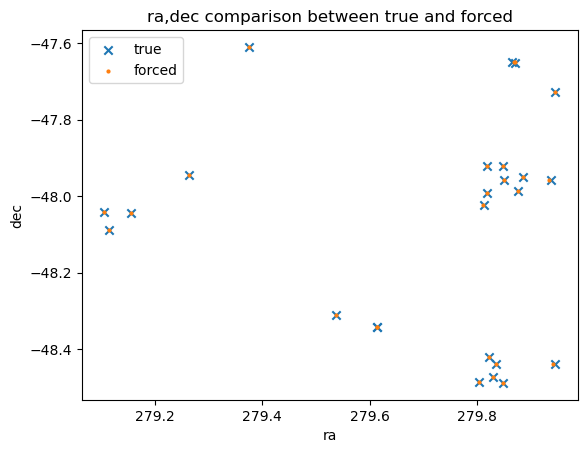

In [73]:
# compare ra,dec between true and forced as 2d scatter plot
plt.scatter(match_df['true_ra'], match_df['true_dec'], marker='x', label='true')
plt.scatter(match_df['forced_ra'], match_df['forced_dec'], marker='o', s=4, label='forced')
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('ra,dec comparison between true and forced')
plt.show()

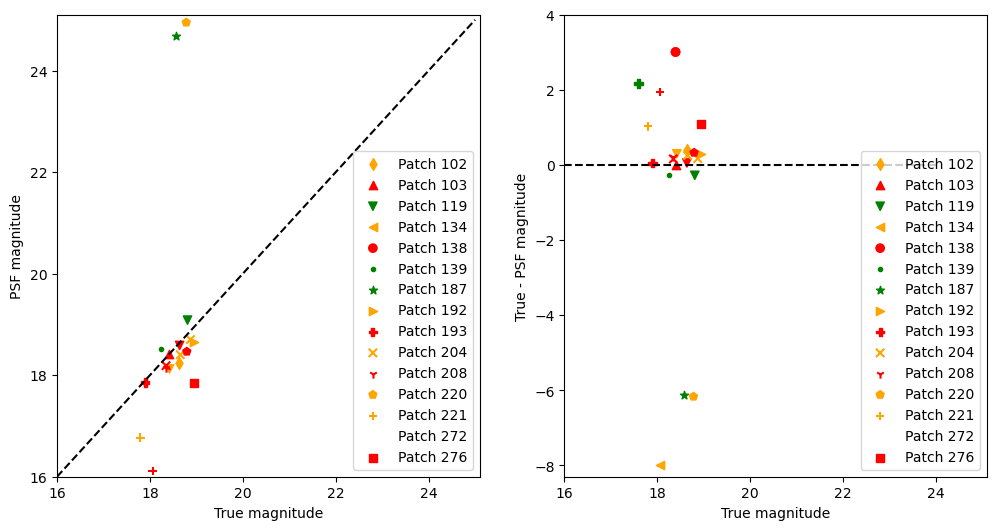

In [78]:
# create a two panel plot of PSF vs True and True - PSF Vs True
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

colors = {'r': 'red', 'g': 'green', 'i':'orange'}
markers= {102: 'd', 103: '^', 119:'v', 134: '<', 138: 'o', 139: '.', 187: '*', 192: '>', 193:'P', 204: 'x', 208: '1', 220:'p', 221:'+', 272: '', 276:'s'}
for marker_value, marker_style in markers.items():
    subset = match_df[match_df['patch'] == marker_value]
    ax[0].scatter(subset['true_magnorm'], subset['forced_mag'], 
                c=subset['forced_band'].map(colors), marker=marker_style, label=f'Patch {marker_value}')
    ax[1].scatter(subset['true_magnorm'], subset['diff_mag'], 
                c=subset['forced_band'].map(colors), marker=marker_style, label=f'Patch {marker_value}')

    
ax[0].plot([16.0, 25.0], [16.0, 25.0], ls='--', color='k')
ax[0].set_xlabel('True magnitude')
ax[0].set_ylabel('PSF magnitude')
#set limits
ax[0].set_xlim(16.0, 25.1)
ax[0].set_ylim(16.0, 25.1)
ax[0].legend(loc='lower right')

ax[1].plot([16.0, 24.0], [0.0, 0.0], ls='--', color='k')
ax[1].set_xlabel('True magnitude')
ax[1].set_ylabel('True - PSF magnitude')
#set limits
ax[1].set_xlim(16.0, 25.1)
ax[1].set_ylim(-8.3, 4.0)
ax[1].legend(loc='lower right')



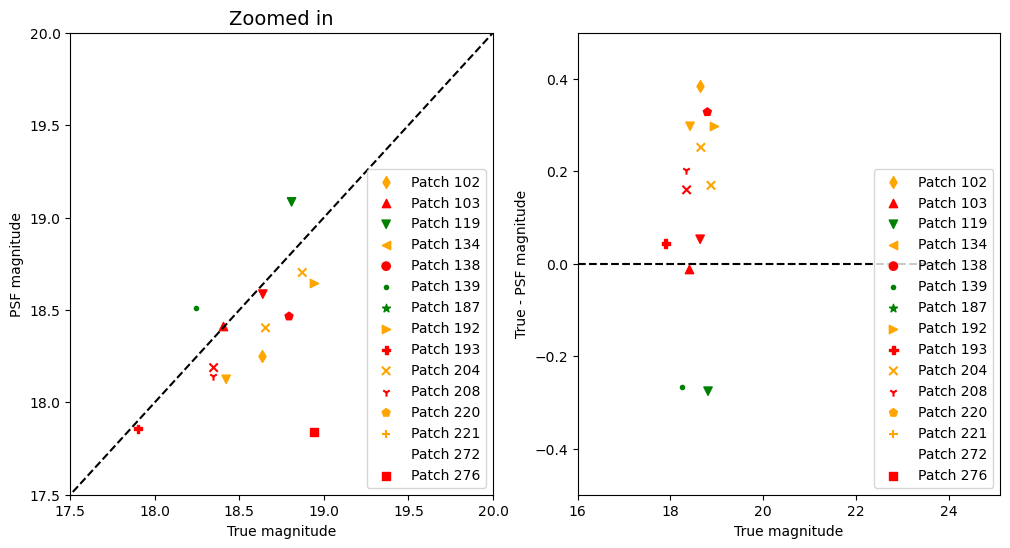

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

colors = {'r': 'red', 'g': 'green', 'i':'orange'}
markers= {102: 'd', 103: '^', 119:'v', 134: '<', 138: 'o', 139: '.', 187: '*', 192: '>', 193:'P', 204: 'x', 208: '1', 220:'p', 221:'+', 272: '', 276:'s'}
for marker_value, marker_style in markers.items():
    subset = match_df[match_df['patch'] == marker_value]
    ax[0].scatter(subset['true_magnorm'], subset['forced_mag'], 
                c=subset['forced_band'].map(colors), marker=marker_style, label=f'Patch {marker_value}')
    ax[1].scatter(subset['true_magnorm'], subset['diff_mag'], 
                c=subset['forced_band'].map(colors), marker=marker_style, label=f'Patch {marker_value}')

    
ax[0].plot([16.0, 25.0], [16.0, 25.0], ls='--', color='k')
ax[0].set_xlabel('True magnitude')
ax[0].set_ylabel('PSF magnitude')
#set limits
ax[0].set_xlim(17.5, 20.0)
ax[0].set_ylim(17.5, 20.0)
ax[0].legend(loc='lower right')
ax[0].set_title('Zoomed in', fontsize=14)

ax[1].plot([16.0, 24.0], [0.0, 0.0], ls='--', color='k')
ax[1].set_xlabel('True magnitude')
ax[1].set_ylabel('True - PSF magnitude')
#set limits
ax[1].set_xlim(16.0, 25.1)
ax[1].set_ylim(-0.5, 0.5)
ax[1].legend(loc='lower right')


In [88]:
match_df[['patch', 'forced_band','diff_mag']]

,patch,forced_band,diff_mag
23,102,i,0.385555
21,103,r,-0.010876
25,119,g,-0.275870
22,119,i,0.297469
24,119,r,0.053016
20,134,i,-8.001070
14,138,r,3.007695
13,138,r,3.007695
4,139,g,-0.266226
8,187,g,-6.121500
